# Figure 5, Noise in feedback signal

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import StrMethodFormatter

import seaborn as sns

import a.lib.dataloader as dl
from a.lib.tools import dist, lpf, converged

In [2]:
# Set figure aesthetics
sns.set_context("notebook")
sns.set_style("ticks")
fs = 14
seeds_n = 30

## LIF

In [3]:
# Load data
data = dl.DataLoader("./a/results/", "temporal_noise_3").merge()

36.285
38.913
45.051


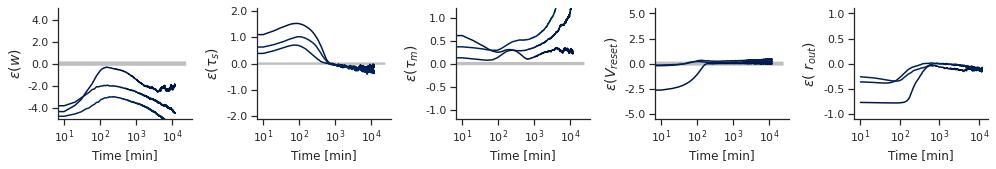

In [4]:
# Plot diverging training trajectories
sns.set_palette(['#001649', '#001d50', '#002359', '#002a61', '#00316a', '#003872', '#00407a',
                 '#004783', '#004f8b', '#005694', '#005e9d', '#0066a5', '#006dae', '#0e75b7',
                 '#227cbf', '#3084c7', '#3b8bcf', '#4593d7', '#4f9adf', '#59a2e8', '#62aaf0',
                 '#6bb2f9', '#74bafe', '#7ec3ff', '#88ccff', '#91d5ff', '#9bdeff', '#a5e7ff',
                 '#aef0ff', '#b7f9ff'])

training_steps = len(data["tau_s"][0]) * 10
x = np.linspace(0., training_steps, len(data["tau_s"][0]))

fig, axs = plt.subplots(1, 5, figsize=(14, 2.5))
for i in range(data["ws"].shape[0]):
    if data["firing_rate_target"][i] < 30.:
        continue
    print(data["firing_rate_target"][i])
    scatter_x = data["ws"][i].shape[1] * 1.1
    axs[0].semilogx(x, dist(data["ws"][i].T, data["ws_target"][i]))
    axs[1].semilogx(x, dist(data["tau_s"][i], data["tau_s_target"][i]))
    axs[2].semilogx(x, dist(data["tau_m"][i], data["tau_m_target"][i]))
    axs[3].semilogx(x, dist(data["v_reset"][i], data["v_reset_target"][i]))
    axs[4].semilogx(x[1:], dist(lpf(data["firing_rate"][i][1:], 0.1), data["firing_rate_target"][i]))

axs[0].set_ylim([-5., 5.])
axs[1].set_ylim([-2.1, 2.1])
axs[2].set_ylim([-1.2, 1.2])
axs[3].set_ylim([-5.5, 5.5])
axs[4].set_ylim([-1.1, 1.1])

for i in [0, 3]:
    axs[i].fill_between(x * 2., 0.15, -0.15, color=[0.75, 0.75, 0.75])
for i in [1, 2]:
    axs[i].fill_between(x * 2., 0.025, -0.025, color=[0.75, 0.75, 0.75])  

axs[0].set_ylabel("$\epsilon (w)$", fontsize=fs)
axs[1].set_ylabel("$\epsilon (\\tau_s)$", fontsize=fs)
axs[2].set_ylabel("$\epsilon (\\tau_m)$", fontsize=fs)
axs[3].set_ylabel("$\epsilon (V_{reset})$ ", fontsize=fs)
axs[4].set_ylabel("$\epsilon (\ r_{out})$", fontsize=fs)

for i in range(5):
    axs[i].yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

for i in range(5):
    sns.despine(ax=axs[i])
    axs[i].set_xlabel("Time [min]")
    axs[i].set_xticks([10., 100., 1000., 10000.])

fig.tight_layout()

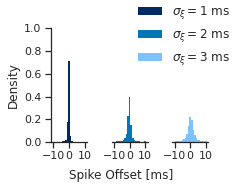

In [5]:
# Create divergence histograms
hists = {0: [], 1: [], 2: []}

for j in range(3):
    data = dl.DataLoader("./a/results/", "temporal_noise_"+str(j+1)).merge()
    for k in range(30):
        student_spike_times = data["eval_100_student"][k]
        teacher_spike_times = data["eval_100_teacher"][k]
        
    for i, (student_spike_times, teacher_spike_times) in enumerate([(student_spike_times, teacher_spike_times)]):
        diffs = []
        for student_spike in student_spike_times:
            nearest_teacher_spike = np.argmin(np.abs(teacher_spike_times - student_spike))
            diffs.append(student_spike - teacher_spike_times[nearest_teacher_spike])
        hist = np.histogram(diffs, density=True, bins=21, range=(-10, 11))[0]
        if np.any(np.isnan(hist)):
            continue
        hists[j].append(hist)

# Plot
colors = sns.color_palette(['#002a61', '#0675b6', '#7dc2ff'])

fig, axs = plt.subplots(1, 3, figsize=(3.2, 2.5))
for i in range(3):
    label = "$\sigma_{\\xi} = $" + str(i+1) + " ms"
    axs[i].bar(np.linspace(-10, 10, 21), np.mean(hists[i], axis=0), label=label, color=colors[i], linewidth=0, width=1.)
    sns.despine(ax=axs[i], left=i>0)
    if i > 0.:
        axs[i].set_yticks([])
    axs[i].set_ylim(0., 1.)
axs[0].set_ylabel("Density")
axs[0].set_xlabel(" ")
fig.text(0.55, 0.07, "Spike Offset [ms]", ha="center")
fig.legend(loc=(0.57, 0.62), frameon=False, fontsize=12)
fig.tight_layout()

fig.savefig("figure-5-a.svg", pad_inches=0.)

## LRF

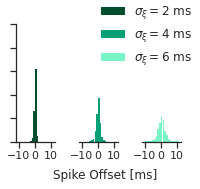

In [6]:
# Create divergence histograms
hists = {0: [], 1: [], 2: []}

for l, j in enumerate([2, 4, 6]):
    data = dl.DataLoader("./b/results/", "temporal_noise2_"+str(j)).merge()
    for k in range(30):
        student_spike_times = data["eval_100_student"][k]
        teacher_spike_times = data["eval_100_teacher"][k]
        
    for i, (student_spike_times, teacher_spike_times) in enumerate([(student_spike_times, teacher_spike_times)]):
        diffs = []
        for student_spike in student_spike_times:
            nearest_teacher_spike = np.argmin(np.abs(teacher_spike_times - student_spike))
            diffs.append(student_spike - teacher_spike_times[nearest_teacher_spike])
        hist = np.histogram(diffs, density=True, bins=21, range=(-10, 11))[0]
        if np.any(np.isnan(hist)):
            continue
        hists[l].append(hist)

# Plot
colors = sns.color_palette(['#004e2b', '#03a075', '#79f5c5'])

fig, axs = plt.subplots(1, 3, figsize=(2.8, 2.5))
for i, j in enumerate([2, 4, 6]):
    label = "$\sigma_{\\xi} = $" + str(j) + " ms"
    axs[i].bar(np.linspace(-10, 11, 21), np.mean(hists[i], axis=0), label=label, color=colors[i], linewidth=0, width=1.)
    sns.despine(ax=axs[i], left=i>0)
    if i > 0.:
        axs[i].set_yticks([])
    axs[i].set_ylim(0., 1.)
#axs[0].set_ylabel("Density")
axs[0].set_yticklabels([])
axs[0].set_xlabel(" ")
fig.text(0.55, 0.07, "Spike Offset [ms]", ha="center")
fig.legend(loc=(0.48, 0.62), frameon=False, fontsize=12)
fig.tight_layout()

fig.savefig("figure-5-b.svg", pad_inches=0.)